# 1. Preparing the Dataset

### I. Importing the Libraries

In [1]:
import numpy as np
import os
from PIL import Image

### II. Loading the dataset

In [2]:
data = np.load('/kaggle/input/pneumoniamnist/pneumoniamnist.npz')

### III. Inspecting the dataset

In [3]:
print(data.files)

['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']


### IV. Splitting the Dataset and Saving them in Different Subfolders

In [4]:
splits = ['train', 'val', 'test']
"""
The dataset from source was already splitted in 78:10:12 for train, val and test sets respectively, 
which is well-balanced, appropriate, and justified for this task.
"""
for split in splits:
    images_key = f'{split}_images'
    labels_key = f'{split}_labels'

    images = data[images_key]     # Shape: (N, H, W)
    labels = data[labels_key]     # Shape: (N,)

    # Create output directories
    images_dir = f'/kaggle/working/{split}/images'
    labels_dir = f'/kaggle/working/{split}/labels'
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for i, (img, label) in enumerate(zip(images, labels)):
        # Normalize and convert to uint8
        if img.dtype != np.uint8:
            img = (255 * (img - img.min()) / img.ptp()).astype(np.uint8)

        # Save image
        img_pil = Image.fromarray(img, mode='L')
        img_path = os.path.join(images_dir, f'{i}.png')
        img_pil.save(img_path)

        # Convert label to plain scalar string
        clean_label = int(label) if isinstance(label, (np.generic, np.ndarray)) else label
        label_path = os.path.join(labels_dir, f'{i}.txt')
        with open(label_path, 'w') as f:
            f.write(str(clean_label))

    print(f"Saved {len(images)} {split} images and labels.")

data.close()

/tmp/ipykernel_19/186239371.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  clean_label = int(label) if isinstance(label, (np.generic, np.ndarray)) else label


Saved 3882 train images and labels.
Saved 524 val images and labels.
Saved 624 test images and labels.


# 2. Preparation for Training

### I. Load the Libraries and Connecting to the Virtual GPU

In [5]:
import tensorflow as tf

strategy = tf.distribute.get_strategy()  # works for GPU/CPU
print("Using GPU:", tf.config.list_physical_devices('GPU'))


2025-07-07 22:39:29.045795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751927969.440380      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751927969.545001      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### II. Set Global Config

In [6]:
IMG_SIZE = 75
BATCH_SIZE = 32
EPOCHS = 50

BASE_PATH = "/kaggle/working/"

TRAIN_IMG_DIR = f"{BASE_PATH}/train/images"
TRAIN_LBL_DIR = f"{BASE_PATH}/train/labels"
VAL_IMG_DIR   = f"{BASE_PATH}/val/images"
VAL_LBL_DIR   = f"{BASE_PATH}/val/labels"
TEST_IMG_DIR  = f"{BASE_PATH}/test/images"
TEST_LBL_DIR  = f"{BASE_PATH}/test/labels"

### III. Dataset Loader

In [7]:
import os

def parse_txt_label(label_path):
    label = tf.io.read_file(label_path)
    return tf.strings.to_number(label, out_type=tf.float32)

def load_image_label(image_path, label_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    label = parse_txt_label(label_path)
    return image, label

def create_dataset(img_dir, lbl_dir, training=False):
    image_filenames = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
    image_paths = [os.path.join(img_dir, f) for f in image_filenames]
    label_paths = [os.path.join(lbl_dir, f.replace(".png", ".txt")) for f in image_filenames]

    ds = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    ds = ds.map(load_image_label, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000).repeat()
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### IV. Create the dataset for training

In [8]:
train_ds = create_dataset(TRAIN_IMG_DIR, TRAIN_LBL_DIR, training=True)
val_ds   = create_dataset(VAL_IMG_DIR, VAL_LBL_DIR)
test_ds  = create_dataset(TEST_IMG_DIR, TEST_LBL_DIR)

I0000 00:00:1751927993.170687      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751927993.171450      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# 3. Compute Class Weights

In [9]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
"""
This step ensures the proper handling of mitigating class imbalances on training set
"""
# Read all labels from .txt files
label_values = []
for lbl_file in sorted(os.listdir(TRAIN_LBL_DIR)):
    with open(os.path.join(TRAIN_LBL_DIR, lbl_file), 'r') as f:
        label_values.append(int(f.read().strip()))

# FIX: Convert classes to np.ndarray
classes = np.array([0, 1])

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=label_values
)

class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}
print("Class Weights:", class_weights)

Class Weights: {0: 5.002577319587629, 1: 0.5555237550085862}


# 4. Building the InceptionV3 Model

In [10]:
from tensorflow.keras import layers, models

with strategy.scope():
    # Define augmentation pipeline
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),       # flip X-ray left-right
        layers.RandomRotation(0.05),           # small rotations
        layers.RandomZoom(0.1),                # simulate closer views
        layers.RandomContrast(0.1)             # vary brightness/contrast
    ])

    # Load pretrained base
    base_model = tf.keras.applications.InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling="avg"
    )
    base_model.trainable = False  # freeze for now

    # Build model pipeline
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)  # logits for binary classification

    model = models.Model(inputs, outputs)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.AUC(name="AUC"),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
        ]
    )


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Plot and Save Training Metrics from Keras History

In [11]:
import matplotlib.pyplot as plt

def plot_history(history, prefix=""):
    """
    Plots training and validation metrics from a Keras history object.
    Saves each plot as PNG and displays it.
    """
    metrics = ['loss', 'binary_accuracy', 'AUC', 'precision', 'recall']
    
    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.plot(history.history[metric], label=f"Train {metric}", marker='o')
        plt.plot(history.history[f"val_{metric}"], label=f"Val {metric}", marker='s')
        plt.title(f"{prefix} {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Save the plot as PNG
        filename = f"{prefix}_{metric}_{EPOCHS}.png"
        plt.savefig(filename)
        print(f"Saved plot: {filename}")
        plt.show()

# 5. Train (Transfer Learning Phase)

Epoch 1/50


I0000 00:00:1751928013.010859      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - AUC: 0.2683 - binary_accuracy: 0.7697 - loss: 0.4886 - precision: 0.9651 - recall: 0.7919 - val_AUC: 0.6932 - val_binary_accuracy: 0.6328 - val_loss: 0.5561 - val_precision: 0.8473 - val_recall: 0.6148
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.5498 - binary_accuracy: 0.6401 - loss: 0.4221 - precision: 0.9740 - recall: 0.6429 - val_AUC: 0.7931 - val_binary_accuracy: 0.5234 - val_loss: 0.5597 - val_precision: 0.9592 - val_recall: 0.3720
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6976 - binary_accuracy: 0.5124 - loss: 0.4409 - precision: 0.9774 - recall: 0.5031 - val_AUC: 0.7885 - val_binary_accuracy: 0.4980 - val_loss: 0.5756 - val_precision: 0.9841 - val_recall: 0.3272
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.7625 - binary_accuracy: 0.5076 - loss: 0.4281 - precision: 0.9826 - recall: 0.4913 - val_AUC: 0.7950 - val_binary_accuracy: 0.5176 - val_loss: 0.5685 - val_precision: 0.9853 - v

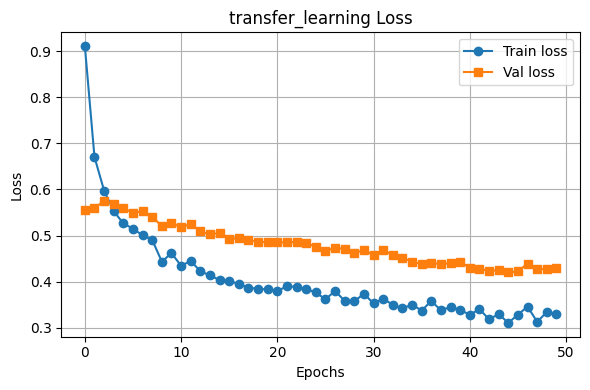

Saved plot: transfer_learning_binary_accuracy_50.png


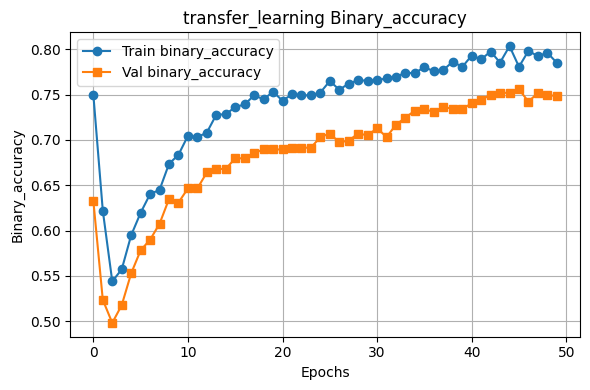

Saved plot: transfer_learning_AUC_50.png


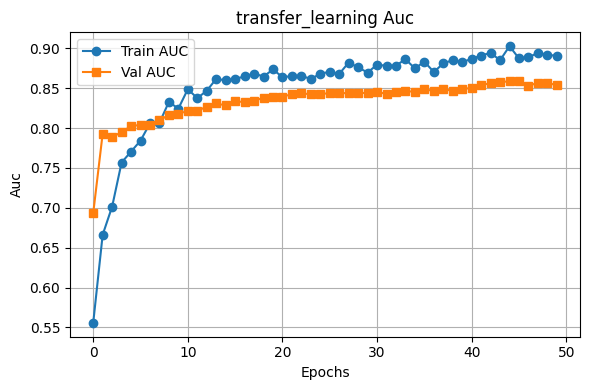

Saved plot: transfer_learning_precision_50.png


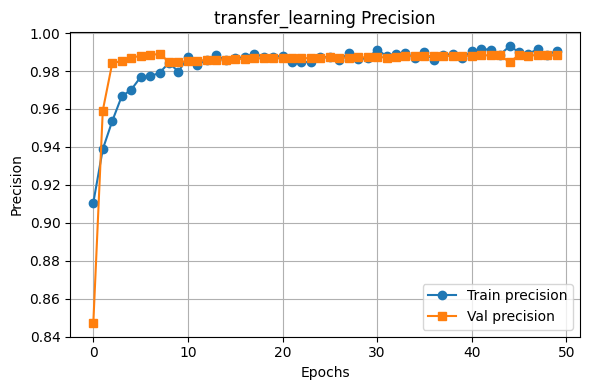

Saved plot: transfer_learning_recall_50.png


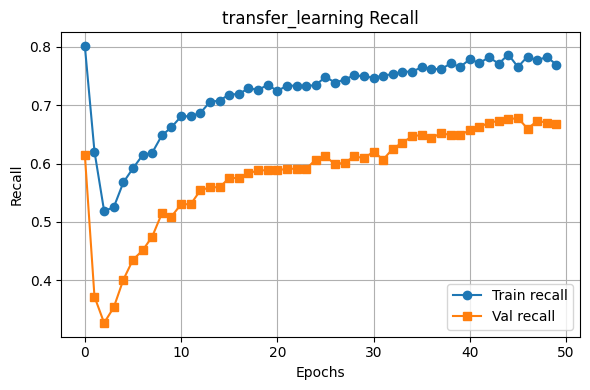

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

STEPS_PER_EPOCH = 3883 // BATCH_SIZE
VAL_STEPS = 524 // BATCH_SIZE

history_transfer = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    class_weight=class_weights
)
plot_history(history_transfer, prefix="transfer_learning")

# 6. Fine-Tuning the InceptionV3 Model

Epoch 1/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 29s 70ms/step - AUC: 0.3334 - binary_accuracy: 0.9223 - loss: 0.4633 - precision: 0.9717 - recall: 0.9468 - val_AUC: 0.8215 - val_binary_accuracy: 0.8652 - val_loss: 0.4054 - val_precision: 0.8744 - val_recall: 0.9551
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.8532 - binary_accuracy: 0.7099 - loss: 0.3352 - precision: 0.9913 - recall: 0.7053 - val_AUC: 0.8700 - val_binary_accuracy: 0.8301 - val_loss: 0.3124 - val_precision: 0.9371 - val_recall: 0.8259
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - AUC: 0.7401 - binary_accuracy: 0.6731 - loss: 0.3520 - precision: 0.9913 - recall: 0.6671 - val_AUC: 0.8485 - val_binary_accuracy: 0.7617 - val_loss: 0.3692 - val_precision: 0.9813 - val_recall: 0.6913
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.8430 - binary_accuracy: 0.6925 - loss: 0.3456 - precision: 0.9939 - recall: 0.6861 - val_AUC: 0.8516 - val_binary_accuracy: 0.7266 - val_loss: 0.3955 - val_precis

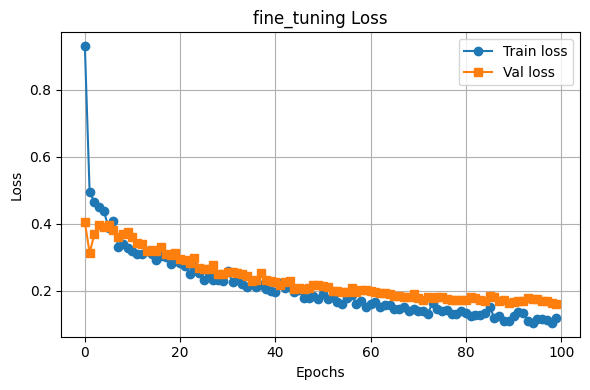

Saved plot: fine_tuning_binary_accuracy_50.png


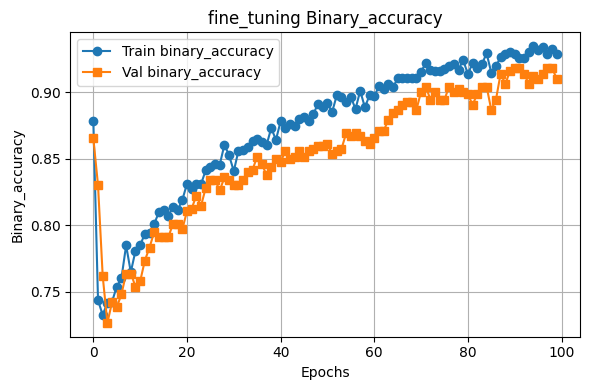

Saved plot: fine_tuning_AUC_50.png


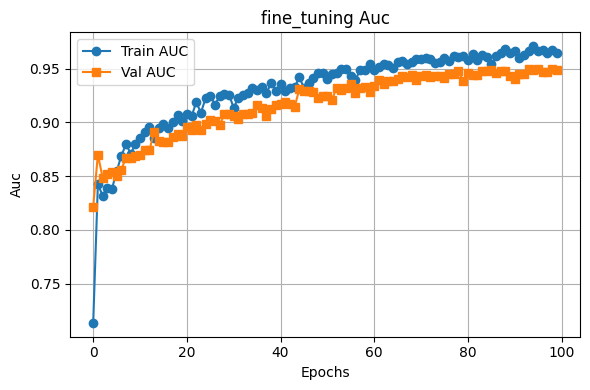

Saved plot: fine_tuning_precision_50.png


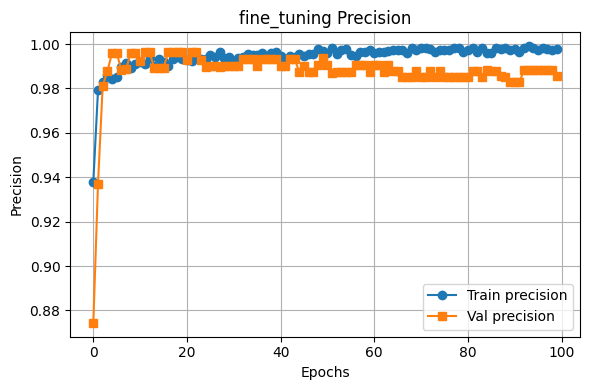

Saved plot: fine_tuning_recall_50.png


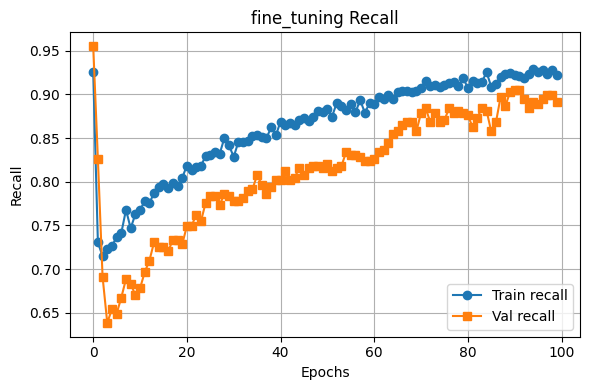

In [13]:
with strategy.scope():
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False  # Fine-tune only last 50 layers

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.AUC(name="AUC"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    class_weight=class_weights
)

plot_history(history_finetune, prefix="fine_tuning")

# 7. Evaluation on Test Set

In [14]:
results = model.evaluate(test_ds)  # Suppress live output
metrics_names = ['loss', 'binary_accuracy', 'AUC', 'precision', 'recall']

print("Test Set Evaluation Metrics:")
for name, val in zip(metrics_names, results):
    print(f" - {name}: {val:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - AUC: 0.8921 - binary_accuracy: 0.8753 - loss: 0.3648 - precision: 0.8906 - recall: 0.9166
Test Set Evaluation Metrics:
 - loss: 0.3434
 - binary_accuracy: 0.8798
 - AUC: 0.8994
 - precision: 0.8889
 - recall: 0.9231


# 8. Generating and plotting the confusion matrix

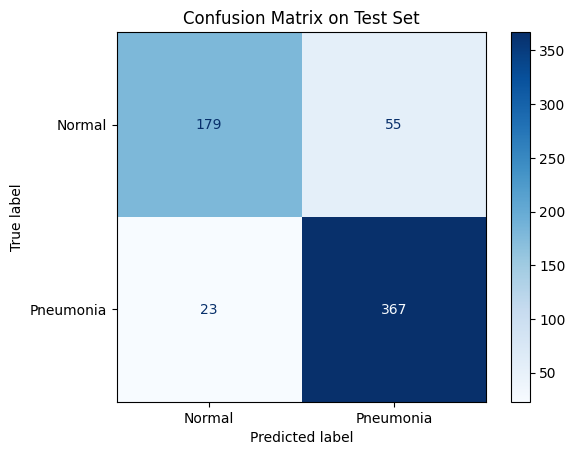

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = []
y_pred = []

for img, lbl in test_ds.unbatch():
    img_expanded = tf.expand_dims(img, axis=0)  # shape becomes (1, H, W, 3)
    logits = model.predict(img_expanded, verbose=0)
    prob = tf.sigmoid(logits)[0][0].numpy()      # convert logits to probability
    predicted_label = int(prob > 0.5)            # threshold at 0.5

    y_true.append(int(lbl.numpy()))
    y_pred.append(predicted_label)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])

disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()

# 9. Testing the model on random image from test set

/tmp/ipykernel_19/3215593904.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = int(pred_prob > 0.5)


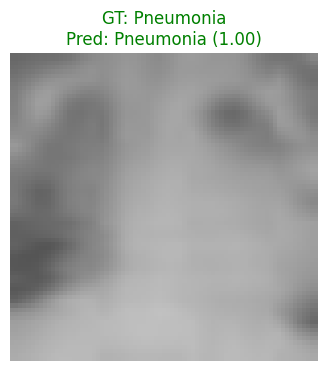

In [16]:
import random
test_images = []
test_labels = []

for img, lbl in test_ds.unbatch():
    test_images.append(img.numpy())
    test_labels.append(lbl.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

def show_random_prediction(model, images, labels, class_names=["Normal", "Pneumonia"]):
    idx = random.randint(0, len(images) - 1)
    img = images[idx]
    true_label = int(labels[idx])

    # Predict
    pred_logits = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_prob = tf.sigmoid(pred_logits)[0].numpy()
    pred_label = int(pred_prob > 0.5)

    # Visual display
    color = "green" if pred_label == true_label else "red"
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"GT: {class_names[true_label]}\nPred: {class_names[pred_label]} ({pred_prob[0]:.2f})",
        color=color,
        fontsize=12
    )
    plt.show()

# 🔍Call this anytime you want to view one prediction
show_random_prediction(model, test_images, test_labels)
